In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import random
import arviz as az
import pymc as pm
import pymc.sampling.jax as pmjax
import numpy as np

import sys; sys.path.append('../')
from misc import h5file
import yaml
import statsmodels.api as sm

In [2]:
noise_lv = 30
fp1 = "./IPI_output_files/PMS_data.h5"
fp2 = "./IPI_output_files/encoded_pde_names.yaml"
X_pre, best_subsets, un, y_pre = h5file(file_path=fp1, mode='r', return_dict=False)

with open(fp2, 'r') as f:
    config = yaml.load(f, yaml.Loader)
f.close()
encoded_feature_names = config["encoded_feature_names"]
encoded_pde_names = config["encoded_pde_names"]
encoded_pde_names

['X_pre', 'best_subsets', 'un', 'y_pre']


['u*u_1',
 'u_11+u*u_1',
 'u_1+u_11+u*u_1',
 'u_1+u_11+u*u_1+u*u*u_11',
 'u+u*u+u_1+u_11+u*u_1',
 'u+u*u+u_1+u_11+u*u_1+u*u*u_11',
 'u+u*u+u_1+u_11+u*u_1+u*u_11+u*u*u_11',
 'u+u*u+u_1+u_11+u*u_1+u*u*u_1+u*u_11+u*u*u_11']

In [3]:
hie = [np.where(best_subsets[i]>0)[0].tolist() for i in range(best_subsets.shape[-1])]

In [4]:
### Version 1 ###
# Define the Bayesian linear regression model
init_beta = np.linalg.lstsq(X_pre, y_pre, rcond=-1)[0]
init_sigma = np.mean((X_pre@init_beta-y_pre)**2)
n_samples = 4000
# n_samples = 40

X_sup = X_pre
y_sup = y_pre.ravel()
support_sizes = X_sup.shape[-1]

np.random.seed(0)
with pm.Model() as model:
    # beta = pm.Normal('beta', mu=0, sigma=1, shape=X_sup.shape[-1])
    # sigma = pm.HalfCauchy('sigma', beta=init_sigma)
    
    xi = pm.Bernoulli('xi', (5/support_sizes)/2, shape=support_sizes)
    beta = pm.MvNormal('beta', 
                       mu=init_beta.flatten(), cov=np.identity(support_sizes), 
                       shape=support_sizes)
    coeffs = pm.Deterministic('coeffs', beta*xi)
    sigma = pm.Exponential('sigma', lam=init_sigma)
    mu = pm.math.dot(X_sup, coeffs)
    likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y_sup)

    # Perform MCMC sampling
    trace = pm.sample(n_samples, tune=n_samples//2, chains=4, cores=4, 
                      # nuts={'target_accept':0.99}, 
                      nuts={'target_accept':0.99, 'max_treedepth':12}, 
                      return_inferencedata=True)
    # trace = pmjax.sample_numpyro_nuts(n_samples, tune=n_samples//2, chains=4, cores=4, return_inferencedata=return_inferencedata)
    # trace = pmjax.sample_blackjax_nuts(n_samples, tune=n_samples//2, chains=4, cores=4, return_inferencedata=True)
    pm.compute_log_likelihood(trace)
    idata = pm.sample_smc(draws=n_samples, progressbar=False, cores=4)

Only 40 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [xi]
>NUTS: [beta, sigma]


Sampling 4 chains for 20 tune and 40 draw iterations (80 + 160 draws total) took 51 seconds.
The number of samples is too small to check convergence reliably.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


The number of samples is too small to check convergence reliably.


In [ ]:
# ### Version 2 (relaxed & faster) ###
# # Define the Bayesian linear regression model
# init_beta = np.linalg.lstsq(X_pre, y_pre, rcond=-1)[0]
# init_sigma = np.mean((X_pre@init_beta-y_pre)**2)
# thin_sigma = 1e-2
# fat_sigma = 1

# n_samples = 4000
# # n_samples = 40

# X_sup = X_pre
# y_sup = y_pre.ravel()
# support_sizes = X_sup.shape[-1]

# np.random.seed(0)
# with pm.Model() as model:    
#     pinclusion = pm.Uniform("pip", 0.0, (5/support_sizes)/2)
#     pip = pm.Bernoulli('xi', pinclusion, shape=support_sizes)
#     coeffs = pm.Normal("coeffs", mu=0, sigma=(1-pip)*thin_sigma+pip*fat_sigma)
# #     coeffs = pm.MvNormal("beta", mu=init_beta.flatten(), 
# #                          sigma=((1-inclusion)*thin_sigma+inclusion*fat_sigma)*np.identity(support_sizes))
    
#     sigma = pm.Exponential('sigma', lam=init_sigma)
#     mu = pm.math.dot(X_sup, coeffs)
#     likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y_sup)

#     # Perform MCMC sampling
#     trace = pm.sample(n_samples, tune=n_samples//2, chains=4, cores=4, 
#                       # nuts={'target_accept':0.99}, 
#                       nuts={'target_accept':0.99, 'max_treedepth':12}, 
#                       return_inferencedata=True)
#     # trace = pmjax.sample_numpyro_nuts(n_samples, tune=n_samples//2, chains=4, cores=4, return_inferencedata=return_inferencedata)
#     # trace = pmjax.sample_blackjax_nuts(n_samples, tune=n_samples//2, chains=4, cores=4, return_inferencedata=True)
#     pm.compute_log_likelihood(trace)
#     idata = pm.sample_smc(draws=n_samples, progressbar=False, cores=4)

In [5]:
# trace = trace.from_netcdf("burgers_99_depth12.trace")
post = trace.posterior

In [6]:
xi_npar = np.array(post.xi)
total_samples = xi_npar.shape[0]*xi_npar.shape[1]
coll = {}
tested = {}
for nc in range(xi_npar.shape[0]):
    for i in range(xi_npar.shape[1]):
        eff = tuple(np.nonzero(xi_npar[nc][i])[0])
        if eff not in tested:
            com = len(eff)
            bicv = sm.OLS(y_pre, X_pre[:, eff]).fit().bic
            if (com not in coll) or (com in coll and coll[com][-1] > bicv):
                coll[len(eff)] = [eff, bicv]
            tested[eff] = 1
        else:
            tested[eff] += 1
for com in coll: 
    coll[com].append(tested[coll[com][0]])
counts = [tested[coll[com][0]] for com in coll]
counts = np.array(counts)
# counts = counts/sum(counts)
counts = counts/total_samples
del tested
coll

{4: [(2, 3, 4, 7), -77447.20457263225, 374],
 3: [(2, 3, 4), -77441.5826689938, 2078],
 2: [(3, 4), -77439.44760272012, 6484],
 5: [(2, 3, 4, 5, 7), -77438.09805649624, 1]}

In [7]:
data = np.array(post.coeffs).reshape(-1, 8)
prob = np.array(post.xi).reshape(-1, support_sizes)
prob = prob.mean(axis=0)
# prob = prob/sum(prob)
index = tuple(np.argsort(prob)[::-1][:max(coll.keys())])
data = data[:, index]

In [8]:
[encoded_feature_names[i] for i in index], index # Set columns accordingly

(['u*u_1', 'u_11', 'u*u*u_1', 'u_1', 'u*u'], (4, 3, 5, 2, 1))

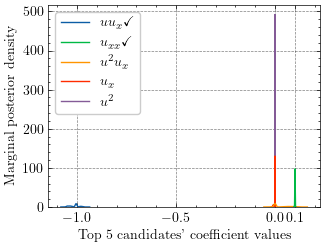

In [12]:
with plt.style.context(['science', 'grid']):
    sns.kdeplot(pd.DataFrame(data, 
                             columns=["$uu_{x}\checkmark$", "$u_{xx}\checkmark$", 
                                      "$u^{2}u_{x}$", "$u_{x}$", "$u^{2}$"]))
    plt.xlabel("Top 5 candidates' coefficient values")
    plt.ylabel("Marginal posterior density")
    plt.xticks([-1., -0.5, 0, 0.1])
#     plt.savefig("../Figures/Burgers/posterior.pdf")
    plt.show()

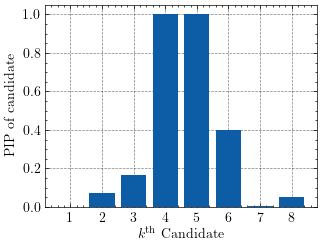

In [10]:
with plt.style.context(['science', 'grid']):
    plt.bar([i+1 for i in range(len(prob))], prob)
    plt.xticks([i+1 for i in range(len(prob))])
    plt.ylabel("PIP of candidate")
    plt.xlabel("$k^{\\text{th}}$ Candidate")
#     plt.savefig("../Figures/Burgers/PIP_candidate.pdf")
    plt.show()

/Users/pongpisit/anaconda3/envs/pymc_env/lib/python3.11/site-packages/matplotlib/ticker.py:2937: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


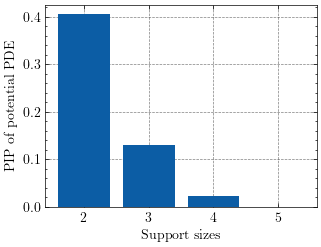

In [11]:
with plt.style.context(['science', 'grid']):
    plt.bar(coll.keys(), counts)
    plt.xticks(list(coll.keys()))
    plt.ylabel("PIP of potential PDE")
    plt.xlabel("Support sizes")
#     plt.savefig("../Figures/Burgers/PIP_model.pdf")
    plt.show()

In [ ]:
# trace.to_netcdf("burgers_99_depth12.trace", overwrite_existing=True)

In [ ]:
# idata.to_json("burgers_99_depth12_idata.json")